# Causal Analysis of Synthetic Dataset

In [5]:
import networkx as nx
import numpy as np
import pandas as pd
import dowhy
import dowhy.plotter as plotter
from dowhy.do_why import CausalModel
import random
import seaborn as sns
from pymatch.Matcher import Matcher

sns.set_context("notebook")
%matplotlib inline

random.seed(0)
np.random.seed(0)

TREATMENT = 'ContinentOfBirth'
#TREATMENT = 'CitizenshipContinent'

TREATMENT_COL = 'Treatment'
OUTCOME = 'LastNameCorrect'

ignore_vars = ['Last Name', OUTCOME, TREATMENT_COL, TREATMENT, 'CountryOfBirth']

In [6]:
dataset = pd.read_csv('data/synthetic-dataset-scenario-B.csv')

In [7]:
# Introduce binary treatment column as proposed by Data X-Ray
dataset[TREATMENT_COL] = dataset[TREATMENT] == 'Asia'
dataset.rename({'Last Name Correct': OUTCOME}, axis=1, inplace=True)
dataset.head()

,Source,Last Name,CountryOfBirth,ContinentOfBirth,CitizenshipCountry,CitizenshipContinent,NumChildren,MaritalStatus,LastNameCorrect,Treatment
0,B,ztyji,China,Asia,China,Asia,2,Married,False,True
1,B,eqjin,Canada,North America,Canada,North America,2,Single,True,False
2,D,npqyp,China,Asia,China,Asia,4,Widowed,False,True
3,A,vwsqy,France,Europe,Canada,North America,4,Widowed,True,False
4,A,jsnjz,Japan,Asia,Japan,Asia,2,Single,True,True


In [40]:
graph = nx.DiGraph()

# potential confounders
for col in dataset.drop(ignore_vars, axis=1).columns:
    graph.add_edge(col, TREATMENT_COL)
    graph.add_edge(col, OUTCOME)
    
#graph.add_edge('Unobserved Confounders', 'Treatment')
#graph.add_edge('Unobserved Confounders', 'Last Name Correct')

# Assumed causal relation
graph.add_edge(TREATMENT_COL, OUTCOME)

['MaritalStatus', 'NumChildren', 'CitizenshipContinent', 'Source', 'CitizenshipCountry']
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
Model to find the causal effect of treatment t on outcome l
Using Matplotlib for plotting


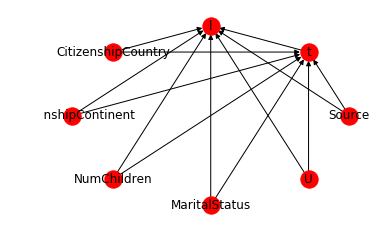

In [41]:
model = CausalModel(data = dataset, treatment=TREATMENT_COL, outcome=OUTCOME, graph=''.join(nx.generate_gml(graph)))
model.view_model()

In [42]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'MaritalStatus', 'NumChildren', 'U', 'CitizenshipContinent', 'Source', 'CitizenshipCountry'}


{'observed': 'yes'}
{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                                                                             
──(Expectation(l|MaritalStatus,NumChildren,CitizenshipContinent,Source,Citizen
dt                                                                            

             
shipCountry))
             
Estimand assumption 1, Unconfoundedness: If U→t and U→l then P(l|t,MaritalStatus,NumChildren,CitizenshipContinent,Source,CitizenshipCountry,U) = P(l|t,MaritalStatus,NumChildren,CitizenshipContinent,Source,CitizenshipCountry)
### Estimand : 2
Estimand name: iv
No such variable found!



In [43]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name='backdoor.propensity_score_matching')
print(causal_estimate)
print('Causal Estimate is ' + str(causal_estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: l~t+MaritalStatus+NumChildren+CitizenshipContinent+Source+CitizenshipCountry


PropensityScoreMatchingEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                                                                             
──(Expectation(l|MaritalStatus,NumChildren,CitizenshipContinent,Source,Citizen
dt                                                                            

             
shipCountry))
             
Estimand assumption 1, Unconfoundedness: If U→t and U→l then P(l|t,MaritalStatus,NumChildren,CitizenshipContinent,Source,CitizenshipCountry,U) = P(l|t,MaritalStatus,NumChildren,CitizenshipContinent,Source,CitizenshipCountry)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: l~t+MaritalStatus+NumChildren+CitizenshipContinent+Source+CitizenshipCountry
## Estimate
Value: -0.1282816229116945

Causal Estimate is -0.1282816229116945


In [44]:
res_random = model.refute_estimate(identified_estimand, causal_estimate, method_name='random_common_cause')
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: l~t+MaritalStatus+NumChildren+CitizenshipContinent+Source+CitizenshipCountry+w_random


Refute: Add a Random Common Cause
Estimated effect:(-0.1282816229116945,)
New effect:(-0.13454653937947494,)



In [45]:
res_placebo = model.refute_estimate(identified_estimand, causal_estimate, method_name='placebo_treatment_refuter', placebo_type='permute')
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: l~placebo+MaritalStatus+NumChildren+CitizenshipContinent+Source+CitizenshipCountry


Refute: Use a Placebo Treatment
Estimated effect:(-0.1282816229116945,)
New effect:(0.015214797136038186,)



In [46]:
res_subset = model.refute_estimate(identified_estimand, causal_estimate, method_name='data_subset_refuter', subset_fraction=0.9)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: l~t+MaritalStatus+NumChildren+CitizenshipContinent+Source+CitizenshipCountry


Refute: Use a subset of data
Estimated effect:(-0.1282816229116945,)
New effect:(-0.1387876780390858,)



## PyMatch

Formula:
LastNameCorrect ~ Source+CitizenshipCountry+CitizenshipContinent+NumChildren+MaritalStatus
n majority: 8978
n minority: 1022
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 65.63%


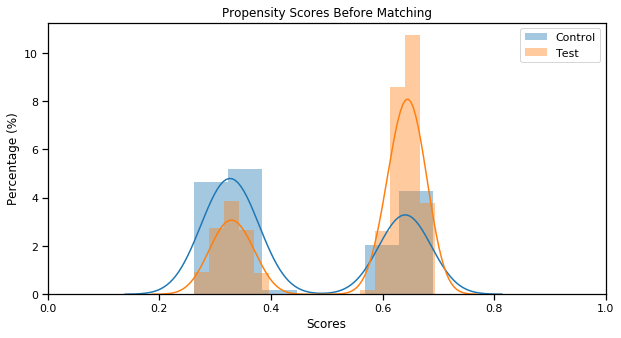

In [8]:
m = Matcher(dataset[dataset[TREATMENT_COL]], dataset[~dataset[TREATMENT_COL]], yvar=OUTCOME, exclude=ignore_vars)
m.fit_scores(balance=True, nmodels=100)
m.predict_scores()
m.plot_scores()

C:\Users\Amnesix\DOCUME~1\KIT---~1\00-AUS~1\Studium\WINTER~1\CAUSAL~1\mldcpy\lib\site-packages\pymatch\Matcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.matched_data['match_id'] = match_ids
C:\Users\Amnesix\DOCUME~1\KIT---~1\00-AUS~1\Studium\WINTER~1\CAUSAL~1\mldcpy\lib\site-packages\pymatch\Matcher.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.matched_data['record_id'] = self.matched_data.index


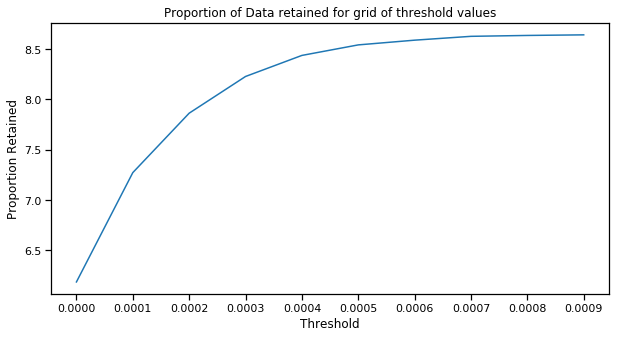

In [9]:
m.tune_threshold(method='random')

In [10]:
m.match(method="min", nmatches=1, threshold=0.0005)
m.record_frequency()

,freq,n_records
0,1,8979
1,3,1
2,4,2
3,5,2
4,6,8
5,7,11
6,8,12
7,9,17
8,10,13
9,11,16


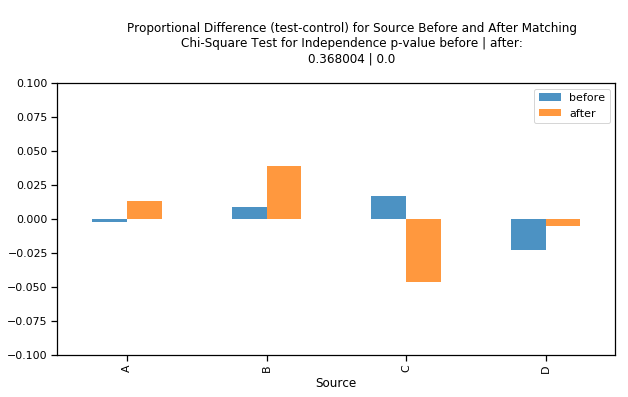

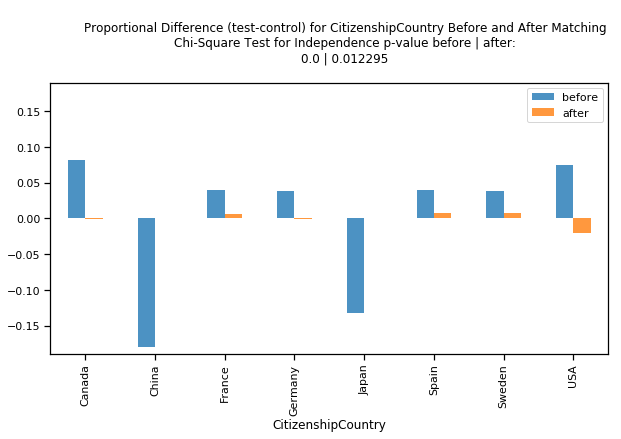

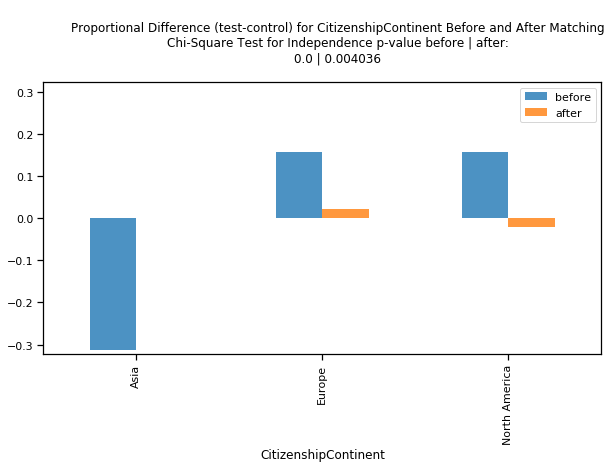

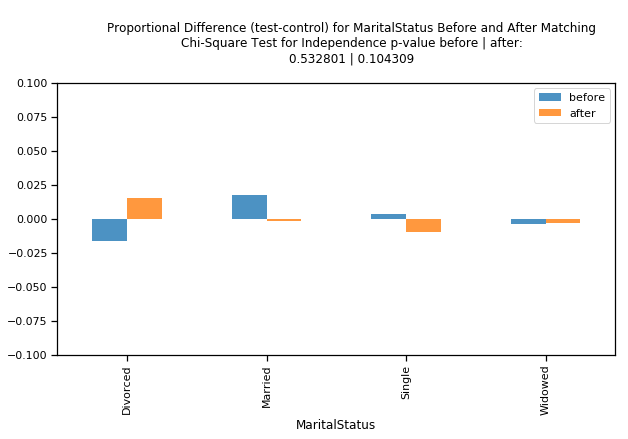

In [11]:
m.assign_weight_vector()
categorical_results = m.compare_categorical(return_table=True)

In [12]:
categorical_results

,var,before,after
0,Source,0.368004,0.000000
1,CitizenshipCountry,0.000000,0.012295
2,CitizenshipContinent,0.000000,0.004036
3,MaritalStatus,0.532801,0.104309


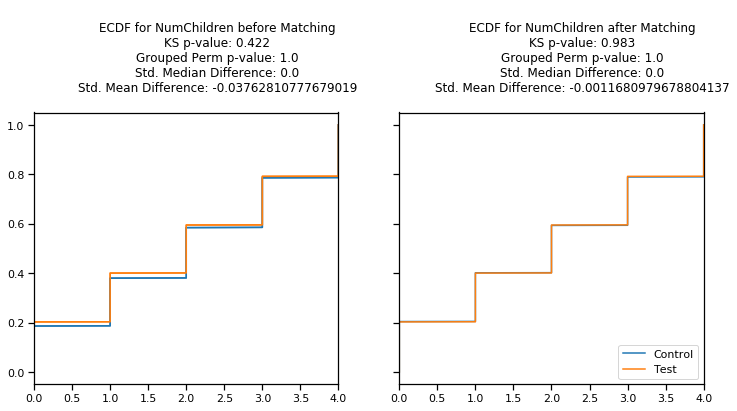

In [13]:
cc = m.compare_continuous(return_table=True)

In [14]:
cc

,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,NumChildren,0.422,0.983,1.0,1.0,0.0,0.0,-0.037628,-0.001168
